In [1]:
import torchvision
import torch
import torch.nn as nn
import numpy as np
from torch import optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
from sklearn.model_selection import train_test_split
import os
from skimage import io
import time
import ast 
from PIL import *
from torchvision import transforms
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [2]:
if torch.cuda.is_available:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [3]:
# subset / old csv
# df = pd.read_csv('temp.csv')

# area larger than 1000
df = pd.read_csv('area_larger_than_1000.csv')

# full dataset 
# df = pd.read_csv('large_nodules_png_bounding_box.csv')

# subset of dataset (25%)
# _ , X_random, = train_test_split(df, test_size=0.25, random_state=0)
# X_random.to_csv('subset.csv',index=False)
# df = X_random

# df.iloc[0,0]
df

,path,imageName,SOPInstanceUID,boxes,areas
0,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000172.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.358253510231...,"[[337.0, 189.0, 376.0, 224.0]]",1365.0
1,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000174.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.332771657417...,"[[335.0, 186.0, 375.0, 225.0]]",1560.0
2,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000019.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.133221309761...,"[[333.0, 189.0, 369.0, 219.0]]",1080.0
3,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000175.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.291261298826...,"[[334.0, 189.0, 374.0, 218.0]]",1160.0
4,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000033.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.122854262319...,"[[112.0, 139.0, 156.0, 189.0]]",2200.0
...,...,...,...,...,...
471,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000119.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.787525847146...,"[[316.0, 313.0, 350.0, 349.0]]",1224.0
472,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000081.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.216953803063...,"[[319.0, 307.0, 350.0, 344.0]]",1147.0
473,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000056.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.182307837643...,"[[313.0, 308.0, 352.0, 346.0]]",1482.0
474,/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-I...,000056.png,1.3.6.1.4.1.14519.5.2.1.6279.6001.182307837643...,"[[181.0, 173.0, 208.0, 211.0]]",1026.0


In [4]:
# split dataset into 60, 20, 20 
train_data, test_data = train_test_split(df, test_size=0.40, random_state=2020)
valid_data, test_data = train_test_split(test_data, test_size=0.50, random_state=2020)
train_data.index = np.arange(len(train_data))
valid_data.index = np.arange(len(valid_data))
test_data.index = np.arange(len(test_data))

In [5]:
train_data.to_csv("large_nodules_train.csv", index=False)
valid_data.to_csv("large_nodules_valid.csv", index=False)
test_data.to_csv("large_nodules_test.csv", index=False)

In [6]:
from torchvision import transforms
# torchvision models are trained on input images normalized to [0 1] range .ToPILImage() function achives this
# additional normalization is required see: http://pytorch.org/docs/master/torchvision/models.html

train_transform = transforms.Compose([
        transforms.ToPILImage(),
#         transforms.RandomResizedCrop(512),
        transforms.CenterCrop(512),
#         transforms.RandomHorizontalFlip(),
        transforms.ToTensor()])
#         transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

validation_transform = transforms.Compose([
        transforms.ToPILImage(),
        transforms.CenterCrop(512),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

class Faster_RCNN_Dataloader(Dataset):
    """Chest X-ray dataset from https://nihcc.app.box.com/v/ChestXray-NIHCC."""

    def __init__(self, csv_file, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file filename information.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.data_frame = pd.read_csv(csv_file)
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        
        # get image path
        img_name = (self.data_frame.iloc[idx, 0])
        
#         # open image 
#         image = io.imread(img_name)
#         # 3 channels
#         image = np.array(image)
        image = cv2.imread(img_name) # Read image with cv2
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#         plt.imshow(image)
        
#         if len(image.shape) > 2 and image.shape[2] == 4:
#             image = image[:,:,0]       
#         image = np.repeat(image[None,...],3,axis=0)
        
        # transform image? 
#         plt.imshow(image)
        if self.transform:
            image = self.transform(np.uint8(image))
#         plt.imshow(image.squeeze().numpy())
        d = {}
        d['boxes'] = torch.FloatTensor(ast.literal_eval(self.data_frame.iloc[idx, 3]))
        d['labels'] = torch.ones([1], dtype=torch.int64)
        
        return image, d

# change dataloader output to lists.
def pad_collate(batch):
    (xx, yy) = zip(*batch)
    return list(xx), list(yy)

In [7]:
train_df_path = 'large_nodules_train.csv'
validate_df_path = 'large_nodules_valid.csv'
test_df_path = 'large_nodules_test.csv'

transformed_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform),
                       'validate':Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform),
                       'test':Faster_RCNN_Dataloader(test_df_path)}
bs = 8

dataloader = {x: DataLoader(transformed_dataset[x], batch_size=bs,
                        shuffle=True, collate_fn = pad_collate, num_workers=0) for x in ['train', 'validate','test']}
data_sizes ={x: len(transformed_dataset[x]) for x in ['train', 'validate','test']}


# one dataloader / phase, may be too memory intensive...

# train_dataset = {'train': Faster_RCNN_Dataloader(train_df_path, transform=train_transform)}
# validate_dataset = {'validate': Faster_RCNN_Dataloader(validate_df_path, transform=validation_transform)}
# test_dataset = {'test': Faster_RCNN_Dataloader(test_df_path)}

# bs = 16 #if bigger, running out of memory in p100

# train_dataloader = {x : DataLoader(train_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['train']}
# validate_dataloader = {x : DataLoader(validate_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['validate']}
# test_dataloader = {x : DataLoader(test_dataset[x], batch_size=bs,
#                         shuffle=True,collate_fn = pad_collate, num_workers=0) for x in ['test']}
# data_sizes ={len(dataset[x]) for x in ['train']}

PNG
(512, 512)
L


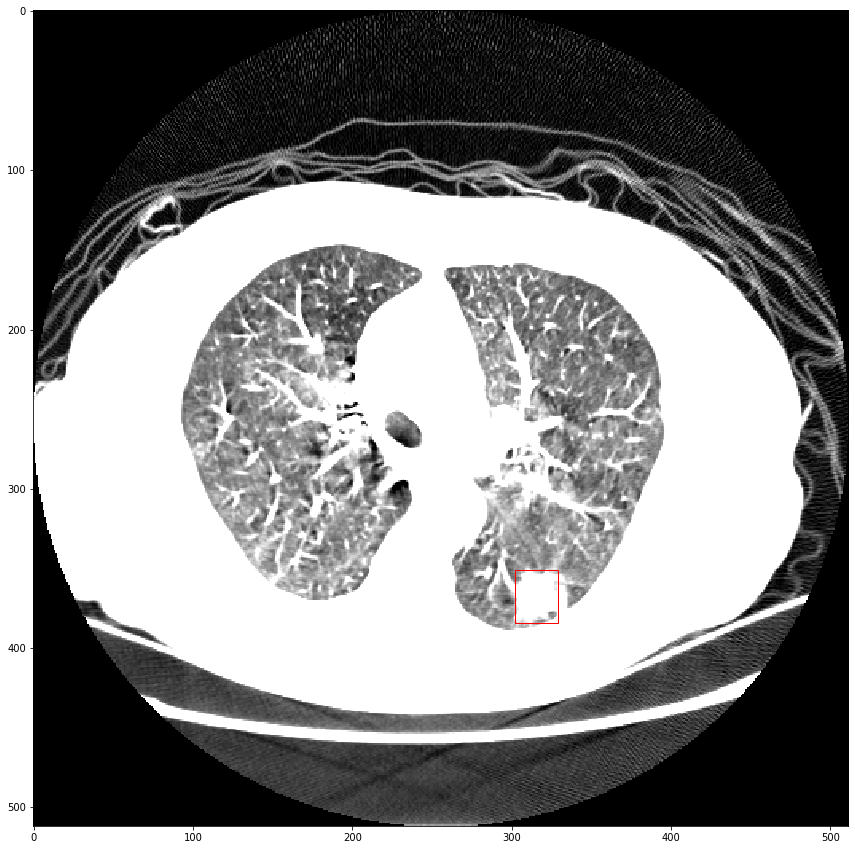

In [8]:
image = Image.open("/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.png")
# plt.imshow(image, cmap="bone")
print(image.format)
print(image.size)
print(image.mode)

path = '/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.png'
boxes = "[[302.0, 351.0, 329.0, 384.0]]"

def box_png(path, boxes):
    boxes = ast.literal_eval(boxes)
    for i in boxes:
            ymin, ymax = i[1],i[3] #ymin ymax        
            xmin, xmax = (i[0]), (i[2]) #xmin, xmax
#     im = np.array(Image.open(path), dtype=np.uint8)
    image = cv2.imread(path) # Read image with cv2
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    fig,ax = plt.subplots(1, figsize=(15,15))
    ax.imshow(image, cmap='gray')
    rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
box_png(path, boxes)

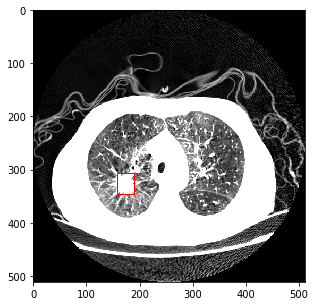

In [9]:
# check if dataloader loaded correctly
# images1, targets1 = next(iter(train_dataloader['train']))
# images2, targets2 = next(iter(validate_dataloader['validate']))
# images3, targets3 = next(iter(test_dataloader['test']))

# to check dim of list dataloader
# len(images) = batch
# len(images[0]) = channel
# len(images[0]) = height
# len(images[0]) = width

# testing dataloader 
images4, targets4 = next(iter(dataloader['train']))

for i in targets4[0]['boxes'].numpy():
    ymin, ymax = i[1],i[3] #ymin ymax        
    xmin, xmax = i[0], i[2] #xmin, xmax
fig,ax = plt.subplots(1, figsize=(5,5))
ax.imshow(images4[0][1].squeeze().numpy(), cmap='gray')
rect = patches.Rectangle((xmin, ymin ),(xmax - xmin),(ymax - ymin),linewidth=1,edgecolor='r',facecolor='none')
ax.add_patch(rect)
plt.show()

In [10]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (nodule) + background

# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features

# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [11]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(pretrained=True).features

# FasterRCNN needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# OrderedDict[Tensor], and in featmap_names you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=["0"],
                                                output_size=7,
                                                sampling_ratio=2)

model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler).to(device)

# tried to run not pretrained.
# model = torchvision.models.detection.fasterrcnn_resnet50_fpn(num_classes=2).to(device)

# for multiple nodes
torch.nn.DataParallel(model)


optimizer = torch.optim.SGD(model.parameters(), lr=1e-5,
                                momentum=0.9, weight_decay=1e-5)

# optimizer = torch.optim.SGD(model.parameters(), lr=0.00001, momentum=0.9, weight_decay=0.0005)

lambda_func = lambda epoch: 0.5 ** epoch
scheduler = optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lambda_func)

# unused 
cel = nn.MSELoss() 

In [12]:
# move dict/lists to gpu 
def move_to(obj, device):
    if torch.is_tensor(obj):
        return obj.to(device)
    elif isinstance(obj, dict):
        res = {}
        for k, v in obj.items():
            res[k] = move_to(v, device)
        return res
    elif isinstance(obj, list):
        res = []
        for v in obj:
            res.append(move_to(v, device))
        return res
    else:
        raise TypeError("Invalid type for move_to")

In [13]:
classes = ['__background__', 'nodule']

In [15]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(float(boxA[0]), float(boxB[0]))
    yA = max(float(boxA[1]), float(boxB[1]))
    xB = min(float(boxA[2]), float(boxB[2]))
    yB = min(float(boxA[3]), float(boxB[3]))
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [16]:
def train_model(model, dataloader,optimizer, scheduler, loss_fn, num_epochs = 10, verbose = True):
    acc_dict = {'train':[]}
    loss_dict = {'train':[], 'validate':[]}
    best_acc = 0
    phases = ['train','validate']
    since = time.time()
    epochLossTrain = list()
#     epochAccTrain = list()
    epochLossValidate = list()
    epochAccValidate = list()
    for i in range(num_epochs):
        print('Epoch: {}/{}'.format(i, num_epochs-1))
        print('-'*10)
        losslist = []
        for p in phases:
            running_correct = 0
            running_loss = 0
            running_total = 0
            if p == 'train':
                model.train()
            else:
                model.eval()   
            num = 0 # calculate which batch --> enumerate not working
            loss = 0.0
            for image, target in dataloader[p]:
                optimizer.zero_grad()
                # move data to gpu
#                 plt.imshow(image[0].squeeze().numpy())
                image = move_to(image,device)
                target = move_to(target,device)
                if (num % 10 == 0):
                    print('{} set | epoch: {:3d} | {:6d}/{:6d} batches'.format(p, i, num + 1, len(dataloader[p])))
                num = num + 1
                
                if p == 'train':
                    # loss = sum of all 4 losses returned
                    output = model((image), target)
                    loss = sum(loss for loss in output.values())
                if p == 'validate':
                    # helps with memory 
                    with torch.no_grad():
                        model.eval()  
                        output = model((image))
                        pred_score = [] # confidence score
                        pred_boxes = [] # bounding box
                        pred_class = [] # predicted class
                        maxIOUs = []
                        # loop through output (len(output) = batch size )
                        for j, out in enumerate(output):
                            # documentation: ['boxes'] = [x1, y1, x2, y2]
                            pred_boxes = [[i[0], i[1], i[2], i[3]] for i in list(out['boxes'].cpu().detach().numpy())]
                            pred_score = list(out['scores'].cpu().detach().numpy())
                            pred_class = [classes[i] for i in list(out['labels'].cpu().numpy())]
                            
                            # get correct label
                            # documentation: # 0 xmin, 1 ymin, 2 xmax, 3 ymax
                            t = target[j]['boxes'].cpu().detach().numpy()[0]
                            
                            # want to input: x min , y max, x max, y min
#                             target_box =  [t[0],t[3],t[2],t[1]]

                            target_box =  [t[0],t[1],t[2],t[3]]
                            
                            # get index of max score - in theory want this one.
#                             index = pred_score.index(max(pred_score))
                            
                            # right now, get iou of every predicted box
                            # and keep max iou 
                            iou = []
                            for ind in pred_boxes:
                                iou.append(bb_intersection_over_union(target_box, ind))
                                maxIOUs.append(max(iou))
                        # sum max iou for each validate run to print out to see if above 0.0
                        epoch_acc = (sum(maxIOUs)/len(maxIOUs))
                # printing average loss / epoch
                num_imgs = len(image)
                running_loss += loss*num_imgs
                running_total += num_imgs
                
                if p == 'train':
                    loss.backward()
                    optimizer.step()
                    
            epoch_loss = float(running_loss/running_total)
            
            # keep epoch loss / accuracy (for validation)
            if p == 'train':
                epochLossTrain.append(epoch_loss)
#                 epochAccTrain.append(epoch_acc)
            if p == 'validate':
                epochLossValidate.append(epoch_loss)
                epochAccValidate.append(epoch_acc)
            if verbose or (i%10 == 0):
                if p == 'train':
                    print('Phase:{}, epoch loss: {:.4f}'.format(p, epoch_loss))
                if p == 'validate':
                    print('Phase:{}, epoch loss: {:.4f} | epoch accuracy: {:.4f}'.format(p, epoch_loss, epoch_acc))
            # old code
#             acc_dict[p].append(epoch_acc)
#             loss_dict[p].append(epoch_loss)      
#             if p == 'validate':
#                 if epoch_acc > best_acc:
#                     best_acc = epoch_acc
#                     best_model_wts = model.state_dict()
#             else:
            # schedule supposed to be under "else:" - not sure what it does...
            if scheduler:
                scheduler.step()
        
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
#     print('Best val acc: {:4f}'.format(best_acc))
    
#     model.load_state_dict(best_model_wts)
#     return model, acc_dict, loss_dict, epochLossTrain, epochLossValidate, epochAccTrain, epochAccValidate
    return model, acc_dict, loss_dict, epochLossTrain ,epochLossValidate, epochAccValidate


In [ ]:
model, acc_dict, loss_dict, epochLossTrain,epochLossValidate,epochAccValidate = train_model(model, dataloader, optimizer, 
                                                                        scheduler, 
                                                                        cel, 
                                                                        num_epochs=20)


Epoch: 0/19
----------
train set | epoch:   0 |      1/    36 batches


/home/ebc308/dl4med/lib/python3.7/site-packages/torch/nn/functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "
/pytorch/torch/csrc/utils/python_arg_parser.cpp:756: UserWarning: This overload of nonzero is deprecated:
	nonzero(Tensor input, *, Tensor out)
Consider using one of the following signatures instead:
	nonzero(Tensor input, *, bool as_tuple)


train set | epoch:   0 |     11/    36 batches
train set | epoch:   0 |     21/    36 batches
train set | epoch:   0 |     31/    36 batches
Phase:train, epoch loss: 1.2168
validate set | epoch:   0 |      1/    12 batches
validate set | epoch:   0 |     11/    12 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.0592
Epoch: 1/19
----------
train set | epoch:   1 |      1/    36 batches
train set | epoch:   1 |     11/    36 batches
train set | epoch:   1 |     21/    36 batches
train set | epoch:   1 |     31/    36 batches
Phase:train, epoch loss: 1.0631
validate set | epoch:   1 |      1/    12 batches
validate set | epoch:   1 |     11/    12 batches
Phase:validate, epoch loss: 0.0000 | epoch accuracy: 0.0283
Epoch: 2/19
----------
train set | epoch:   2 |      1/    36 batches
train set | epoch:   2 |     11/    36 batches
train set | epoch:   2 |     21/    36 batches
train set | epoch:   2 |     31/    36 batches
Phase:train, epoch loss: 1.0333
validate set | epoch:

In [ ]:
plt.plot(epochLossTrain, label = "Epoch Train Loss")
# plt.plot(epochLossValidate, label = "Epoch Validate Loss")
plt.legend(loc = "upper right")

In [ ]:
# plt.plot(epochLossTrain, label = "Epoch Train Loss")
plt.plot(epochAccValidate, label = "Epoch Accuracy")
plt.legend(loc = "upper right")

In [ ]:
def get_prediction(img_path, threshold):
    img = Image.open(img_path) # Load the image
    transform = transforms.Compose([transforms.ToTensor()]) # Defing PyTorch Transform
    img = transform(img) # Apply the transform to the image
#     print(img)
    model.eval()
    img = move_to(img,device)
    pred = model([img]) # Pass the image to the model
#     print(pred_class)
    pred_class = [classes[i] for i in list(pred[0]['labels'].cpu().numpy())] # Get the Prediction Score
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].cpu().detach().numpy())] # Bounding boxes
    pred_score = list(pred[0]['scores'].cpu().detach().numpy()) 
#     print(pred_class)
    pred_t = [pred_score.index(x) for x in pred_score if x > threshold][-1] # Get list of index with score greater than threshold.
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]
    return pred_boxes, pred_class

def object_detection_api(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    boxes, pred_cls = get_prediction(img_path, threshold) # Get predictions
    img = cv2.imread(img_path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    
#     for i in range(len(boxes)):
#         print(boxes)
#         cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th) # Draw Rectangle with the coordinates
#         cv2.putText(img,pred_cls[i], boxes[i][0],  cv2.FONT_HERSHEY_SIMPLEX, text_size, (0,255,0),thickness=text_th) # Write the prediction class
#     plt.figure(figsize=(5,5)) # display the output image
#     plt.imshow(img)
#     plt.xticks([])
#     plt.yticks([])
#     plt.show()
    return boxes
    
path = "/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000003.png"

In [ ]:
df

In [ ]:
path = df.iloc[2,0]
boxes = df.iloc[2,3]


# path = '/scratch/ebc308/tcia/data_png/LIDC-IDRI/LIDC-IDRI-0001/01-01-2000-30178/3000566-03192/000030.png'
# boxes = "[[302.0, 351.0, 329.0, 384.0]]"
# print(boxes)

# print each prediction along with correct bounding box
boxes = ast.literal_eval(boxes)
list_box = []
for i in boxes:
    #xmin #ymax #xmax #ymin
    list_box.append(i[0]) #xmin
    list_box.append(i[1]) #ymin
    list_box.append(i[2]) #xmax
    list_box.append(i[3]) #ymax
    ymin, ymax = int(i[1]),int(i[3]) #ymin ymax        
    xmin, xmax = int(i[0]), int(i[2]) #xmin, xmax
    
box = object_detection_api(path, threshold=0.2)
pred_boxes = [[i[0][0], i[0][1], i[1][0], i[1][1]] for i in list(box)] # Bounding boxes

img = cv2.imread(path) # Read image with cv2
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
for ind in pred_boxes:
    img = cv2.imread(path) # Read image with cv2
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert to RGB
    cv2.rectangle(img, (ind[0], ind[1]),(ind[2], ind[3]),color=(0, 255, 0), thickness=3)
    cv2.rectangle(img, (xmin, ymin),(xmax, ymax),color=(255, 0, 0), thickness=3)
    plt.figure(figsize=(5,5)) # display the output image
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()   
    print(bb_intersection_over_union((list_box),(ind) ))